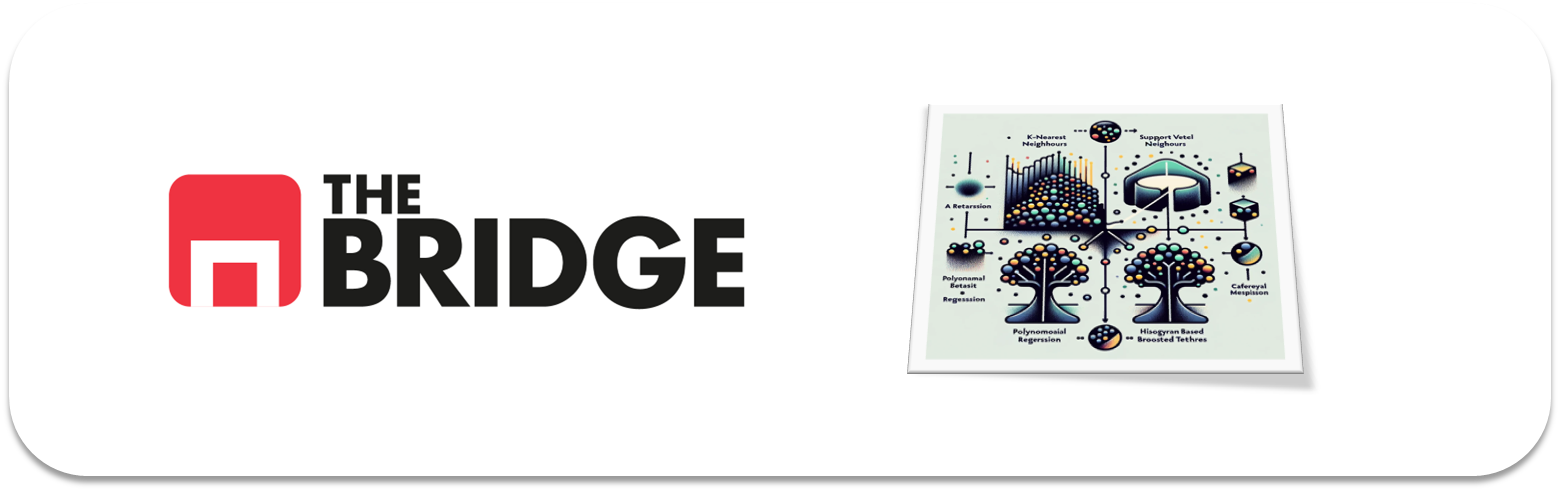

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [3]:
import bootcampviztools as viz

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [4]:
df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

Hay nulos en las variables "MonthlyIncome" y "NumberOfDependents". Dado que no son muchos, eliminamos las filas con nulos

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

Nos sigue quedando un dataset con muchas instancias. Realizamos la clasificación de variables

In [7]:
#Creamos una función para clasificar las variables
def tipifica_variables(df, umbral_categoria, umbral_continua):

    #Creamos una lista con el tipo de cada variable
    lista_tipos = []
        
    #Creamos una lista con la tipificación sugerida para cada variable
    lista_tipificacion = []

    #Creamos dos listas para guardar la cardinalidad de cada variable
    lista_cardinalidad = []
    lista_cardinalidad_porcentaje = []

    #Sugerimos la tipificación de la variable y la guardamos en la lista
    for columna in df.columns:
            
        #Guardamos en la lista el tipo de cada variable
        lista_tipos.append(df[columna].dtypes)
            
        #Calculamos la cardinalidad y la guardamos en las listas
        cardinalidad = df[columna].nunique()
        lista_cardinalidad.append(cardinalidad)
        
        cardinalidad_porcentaje = round(cardinalidad/len(df)*100,2)
        lista_cardinalidad_porcentaje.append(cardinalidad_porcentaje)

        #Clasificamos segun el valor de la cardinalidad
        if cardinalidad == 2:
            lista_tipificacion.append("Binaria")
                
        elif cardinalidad >= umbral_categoria:
                
            if cardinalidad >= umbral_continua:
                lista_tipificacion.append("Numérica continua")
                    
            else: 
                lista_tipificacion.append("Numérica discreta")

        else:
            lista_tipificacion.append("Categórica")

        
    #Creamos el DataFrame con tantas filas como columnas tenga el DataFrame
    df_tipifica = pd.DataFrame({"nombre_variable": df.columns.tolist(), "tipo_variable":lista_tipos, "cardinalidad":lista_cardinalidad, "cardinalidad_porcentaje":lista_cardinalidad_porcentaje , "tipo_sugerido":lista_tipificacion})
    
    return df_tipifica

In [8]:
tipifica_variables(df,umbral_categoria=10,umbral_continua=20)

,nombre_variable,tipo_variable,cardinalidad,cardinalidad_porcentaje,tipo_sugerido
0,SeriousDlqin2yrs,int64,2,0.02,Binaria
1,RevolvingUtilizationOfUnsecuredLines,float64,10314,87.29,Numérica continua
2,age,int64,78,0.66,Numérica continua
3,NumberOfTime30-59DaysPastDueNotWorse,int64,10,0.08,Numérica discreta
4,DebtRatio,float64,11472,97.09,Numérica continua
5,MonthlyIncome,float64,4167,35.27,Numérica continua
6,NumberOfOpenCreditLinesAndLoans,int64,43,0.36,Numérica continua
7,NumberOfTimes90DaysLate,int64,13,0.11,Numérica discreta
8,NumberRealEstateLoansOrLines,int64,16,0.14,Numérica discreta
9,NumberOfTime60-89DaysPastDueNotWorse,int64,8,0.07,Categórica


Clasificamos las variables:
* SeriousDlqin2yrs: Indica si la persona se cataloga como morosa en los últimos 2 años. Tipo: Categórica (Binaria)
* RevolvingUtilizationOfUnsecuredLines: Porcentaje de saldo total de las tarjetas de crédito y las líneas de crédito personales. Tipo: Numérica continua
* age: Edad del prestatario en años. Tipo: Numérica continua
* NumberOfTime30-59DaysPastDueNotWorse: Número de veces que el prestatario ha estado en impago de 30 a 59 días en los últimos 2 años. Tipo: Numérica discreta
* DebtRatio: Porcentaje de pagos mensuales de deudas. Tipo: Numérica continua
* MonthlyIncome: Ingresos mensuales. Tipo: Numérica continua
* NumberOfOpenCreditLinesAndLoans: Número de préstamos abiertos y líneas de crédito. Tipo: Numérica discreta
* NumberOfTimes90DaysLate: Número de veces que el prestatario ha estado 90 días o más en impago. Tipo: Numérica discreta
* NumberRealEstateLoansOrLines: Número de préstamos con garantía hipotecaria. Tipo: Numérica discreta
* NumberOfTime60-89DaysPastDueNotWorse: Número de veces que el prestatario ha estado entre 60 y 89 días en impago en los últimos 2 años. Tipo: Numérica discreta
* NumberOfDependents: Número de personas a cargo en la familia. Tipo: Numérica discreta

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Es un problema de clasificación binaria. Definimos a la variable "SeriousDlqin2yrs" como el *target*

In [9]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

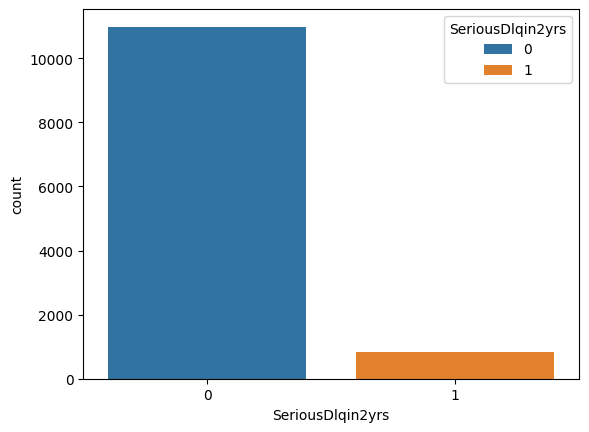

In [10]:
sns.countplot(df, x = target, hue = target);

In [10]:
df[target].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.929756
1    0.070244
Name: proportion, dtype: float64

Obtenemos que el dataset está muy desbalanceado hacia la clase 0 (no tendrá problemas de impago en los próximos 2 años), con un 93% frente a un 7% de la clase 1 (si tendrá problemas de impago en los próximos 2 años)

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

Escogeremos los modelos de Regresión Logística, RandomForest y KNN aplicados a este problema de clasificación. Realizamos la división del DataFrame en train y test con la relación 80/20

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

### 2.1. Proceso EDA

### 2.1.1. Variables numéricas

Realizamos el análisis univariante

In [12]:
columnas_numericas = [columna for columna in df.columns.tolist() if columna != target]
columnas_numericas

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [13]:
train_set.describe()[columnas_numericas].T

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,9452.0,0.335207,0.362233,0.0,0.034869,0.179211,0.587533,6.0
age,9452.0,51.491536,14.499298,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,9452.0,0.343314,2.930489,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,9452.0,0.486047,2.505031,0.0,0.146204,0.297564,0.477876,96.0
MonthlyIncome,9452.0,6868.428058,12580.543336,0.0,3466.000000,5441.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,9452.0,8.794647,5.139555,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,9452.0,0.180279,2.889984,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,9452.0,1.064325,1.148156,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,9452.0,0.152772,2.870119,0.0,0.000000,0.000000,0.000000,98.0
NumberOfDependents,9452.0,0.863415,1.158238,0.0,0.000000,0.000000,2.000000,10.0


(10, 2)


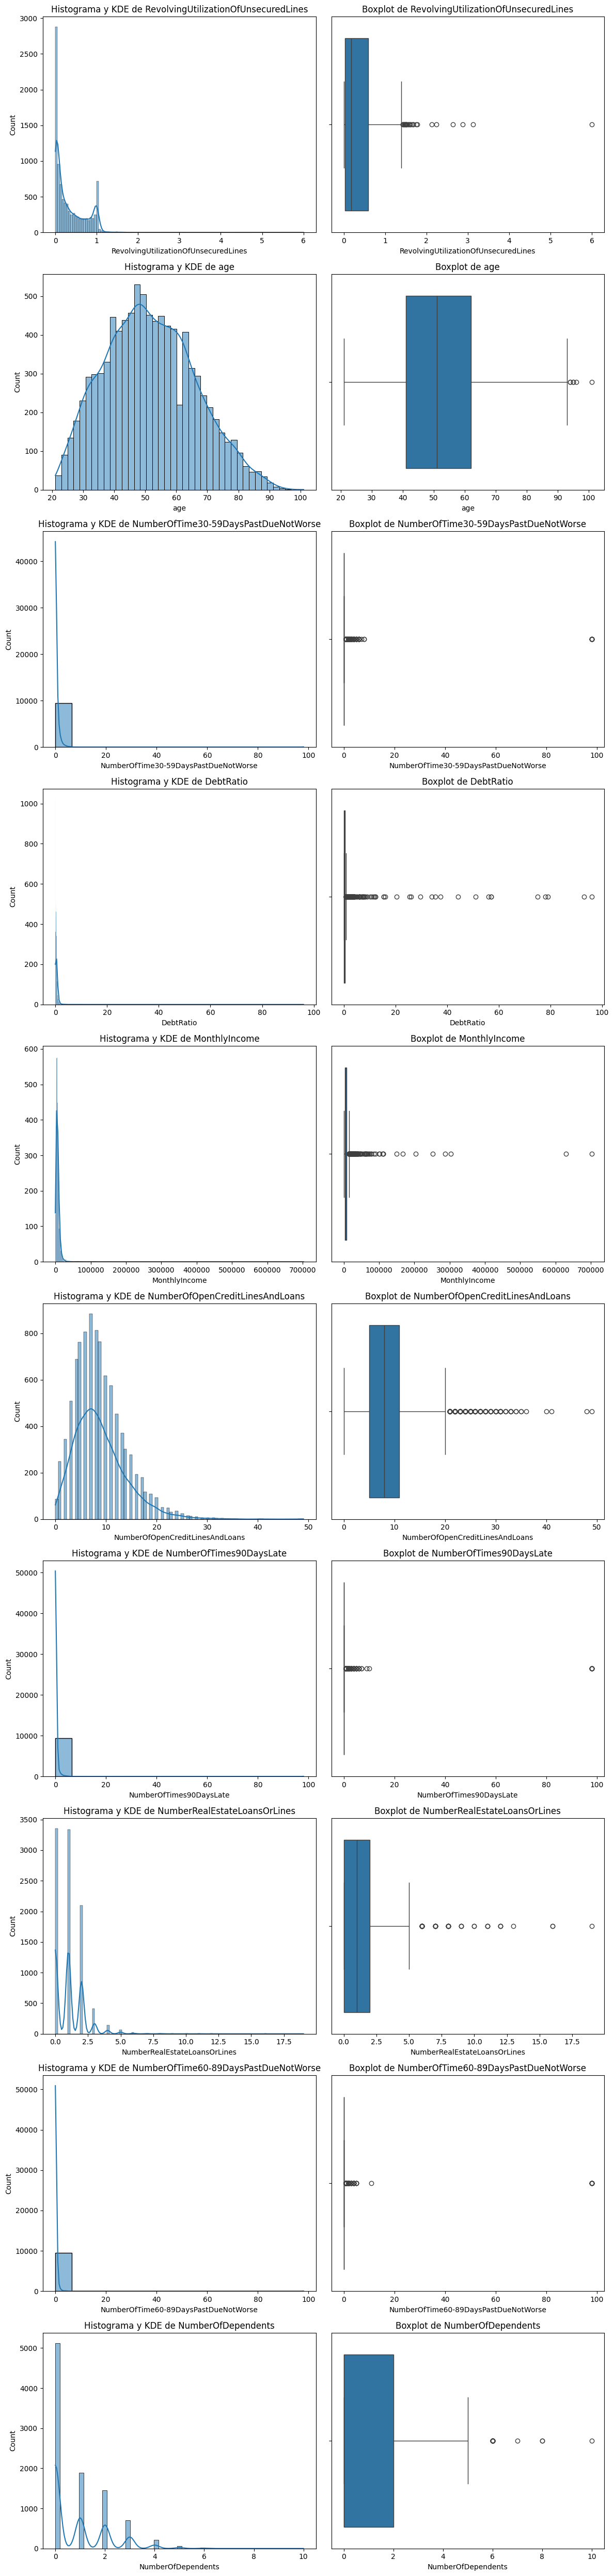

In [14]:
viz.plot_combined_graphs(train_set, columns=columnas_numericas)

Comentarios:

* Las variables "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse" tienen una alta concentración de valores a 0. Las convertiremos en categóricas agrupando

* La variable "NumberRealEstateLoansOrLines" tiene una alta concetración de valores en 0 y 1. La convertiremos en categórica agrupando

* La variable "NumberOfDependents" tiene una alta concetración de valores en 0. La convertiremos en categórica agrupando

* Las variables "RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio", "MonthlyIncome" y "NumberOfOpenCreditLinesAndLoans" tienen rangos de valores diversos lo que habrá que tratarlas

Antes de realizar el análisis bivariante, vamos a convertir en categóricas las variables indicadas en los dos primeros comentarios tanto en train como en test

**Conversión de "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"**

Asignamos el valor 0 para indicar que nunca ha tenido impagos (en los periodos que indica cada variable) y asignamos el valor 1 para indicar que si los ha tenido


In [15]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 0
test_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTime30-59DaysPastDueNotWorse"]>0,"NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 1
test_set.loc[test_set["NumberOfTime30-59DaysPastDueNotWorse"]>0,"NumberOfTime30-59DaysPastDueNotWorse_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"], inplace=True)
test_set.drop(columns=["NumberOfTime30-59DaysPastDueNotWorse"], inplace=True)

#Visualizamos en train
train_set["NumberOfTime30-59DaysPastDueNotWorse_agrupado"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse_agrupado
0    7856
1    1596
Name: count, dtype: int64

In [16]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTimes90DaysLate_agrupado"] = 0
test_set["NumberOfTimes90DaysLate_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTimes90DaysLate"]>0,"NumberOfTimes90DaysLate_agrupado"] = 1
test_set.loc[test_set["NumberOfTimes90DaysLate"]>0,"NumberOfTimes90DaysLate_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTimes90DaysLate"], inplace=True)
test_set.drop(columns=["NumberOfTimes90DaysLate"], inplace=True)

#Visualizamos en train
train_set["NumberOfTimes90DaysLate_agrupado"].value_counts()

NumberOfTimes90DaysLate_agrupado
0    8919
1     533
Name: count, dtype: int64

In [17]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 0
test_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfTime60-89DaysPastDueNotWorse"]>0,"NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 1
test_set.loc[test_set["NumberOfTime60-89DaysPastDueNotWorse"]>0,"NumberOfTime60-89DaysPastDueNotWorse_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"], inplace=True)
test_set.drop(columns=["NumberOfTime60-89DaysPastDueNotWorse"], inplace=True)

#Visualizamos en train
train_set["NumberOfTime60-89DaysPastDueNotWorse_agrupado"].value_counts()

NumberOfTime60-89DaysPastDueNotWorse_agrupado
0    8953
1     499
Name: count, dtype: int64

**Conversión de "NumberRealEstateLoansOrLines"**

Asignamos el valor 0 para indicar que tiene 0 o 1 préstamo con garantía hipotecaria y asignamos el valor 1 para indicar que tiene más de 1 préstamo con garantía hipotecaria


In [18]:
#Inicializamos con un valor para la nueva columna
train_set["NumberRealEstateLoansOrLines_agrupado"] = 0
test_set["NumberRealEstateLoansOrLines_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberRealEstateLoansOrLines"]>1,"NumberRealEstateLoansOrLines_agrupado"] = 1
test_set.loc[test_set["NumberRealEstateLoansOrLines"]>1,"NumberRealEstateLoansOrLines_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberRealEstateLoansOrLines"], inplace=True)
test_set.drop(columns=["NumberRealEstateLoansOrLines"], inplace=True)

#Visualizamos en train
train_set["NumberRealEstateLoansOrLines_agrupado"].value_counts()

NumberRealEstateLoansOrLines_agrupado
0    6690
1    2762
Name: count, dtype: int64

**Conversión de "NumberOfDependents"**

Asignamos el valor 0 para indicar que no tiene personas a cargo y asignamos el valor 1 para indicar que tiene 1 o más personas a cargo

In [19]:
#Inicializamos con un valor para la nueva columna
train_set["NumberOfDependents_agrupado"] = 0
test_set["NumberOfDependents_agrupado"] = 0

#Sustituimos el valor en el caso de que se cumpla la condición
train_set.loc[train_set["NumberOfDependents"]>0,"NumberOfDependents_agrupado"] = 1
test_set.loc[test_set["NumberOfDependents"]>0,"NumberOfDependents_agrupado"] = 1

#Eliminamos la columna inicial
train_set.drop(columns=["NumberOfDependents"], inplace=True)
test_set.drop(columns=["NumberOfDependents"], inplace=True)

#Visualizamos en train
train_set["NumberOfDependents_agrupado"].value_counts()

NumberOfDependents_agrupado
0    5125
1    4327
Name: count, dtype: int64

Realizamos el análisis bivariante de las variables numéricas con el *target*

In [20]:
columnas_numericas = [columna for columna in train_set if "_agrupado" not in columna and columna != target]
columnas_numericas

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

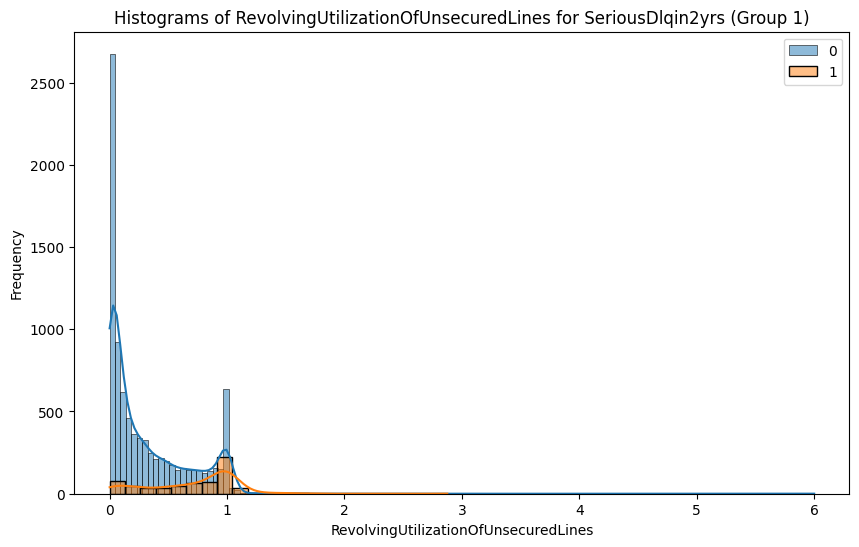

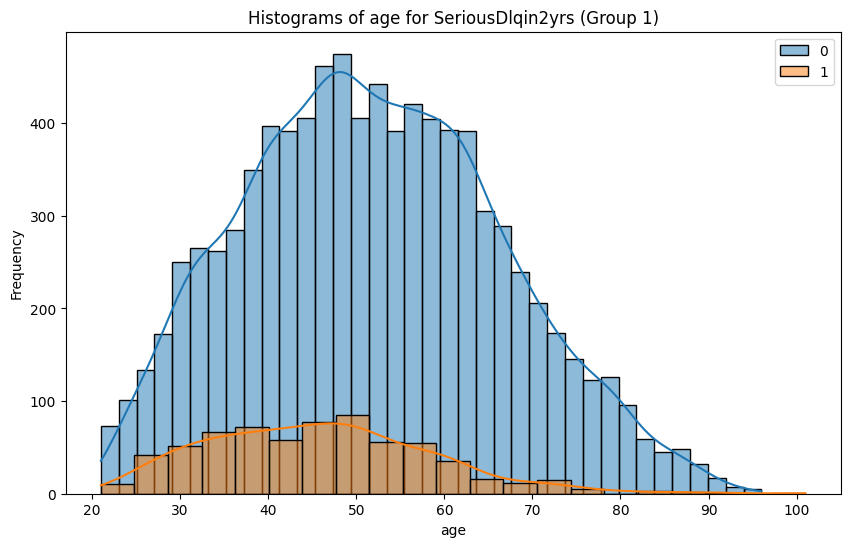

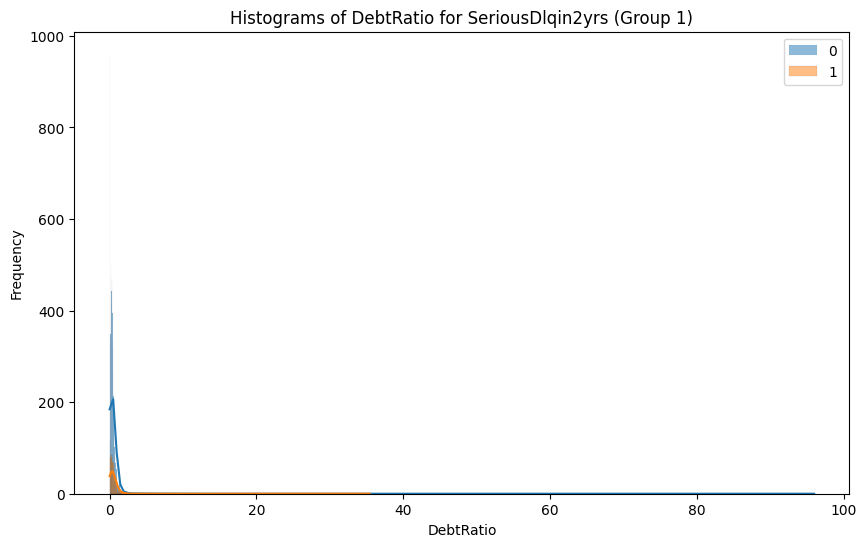

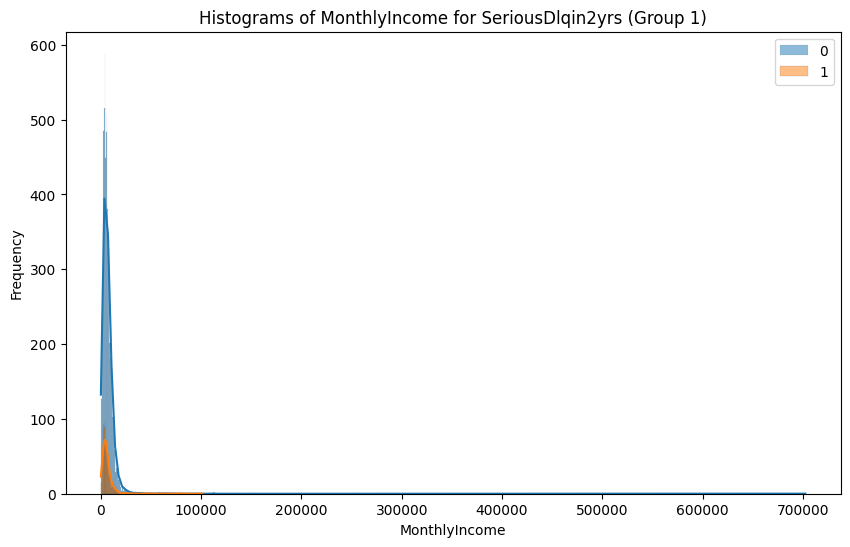

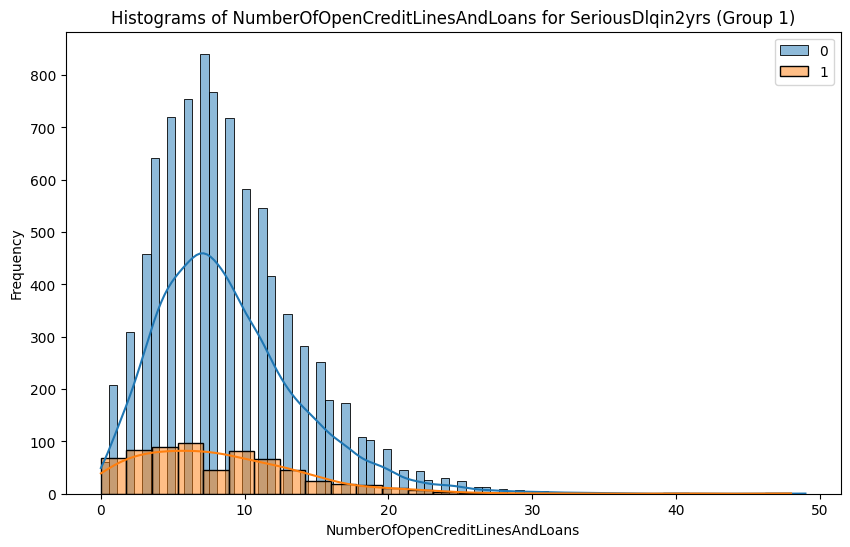

In [21]:
for columna_numerica in columnas_numericas:
    viz.plot_grouped_histograms(train_set, cat_col=target, num_col=columna_numerica, group_size=2)

Observando la distribución de los histogramas no se espera gran cosa de las variable numéricas. No obstante, las incluiremos como *features* numéricas en nuestro modelo

In [22]:
features_num = columnas_numericas
features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

### 2.1.2. Variables categóricas

Realizamos el análisis univariante de las variables categóricas

In [24]:
columnas_categoricas = [columna for columna in train_set if "_agrupado" in columna and columna != target]
columnas_categoricas

['NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado',
 'NumberRealEstateLoansOrLines_agrupado',
 'NumberOfDependents_agrupado']

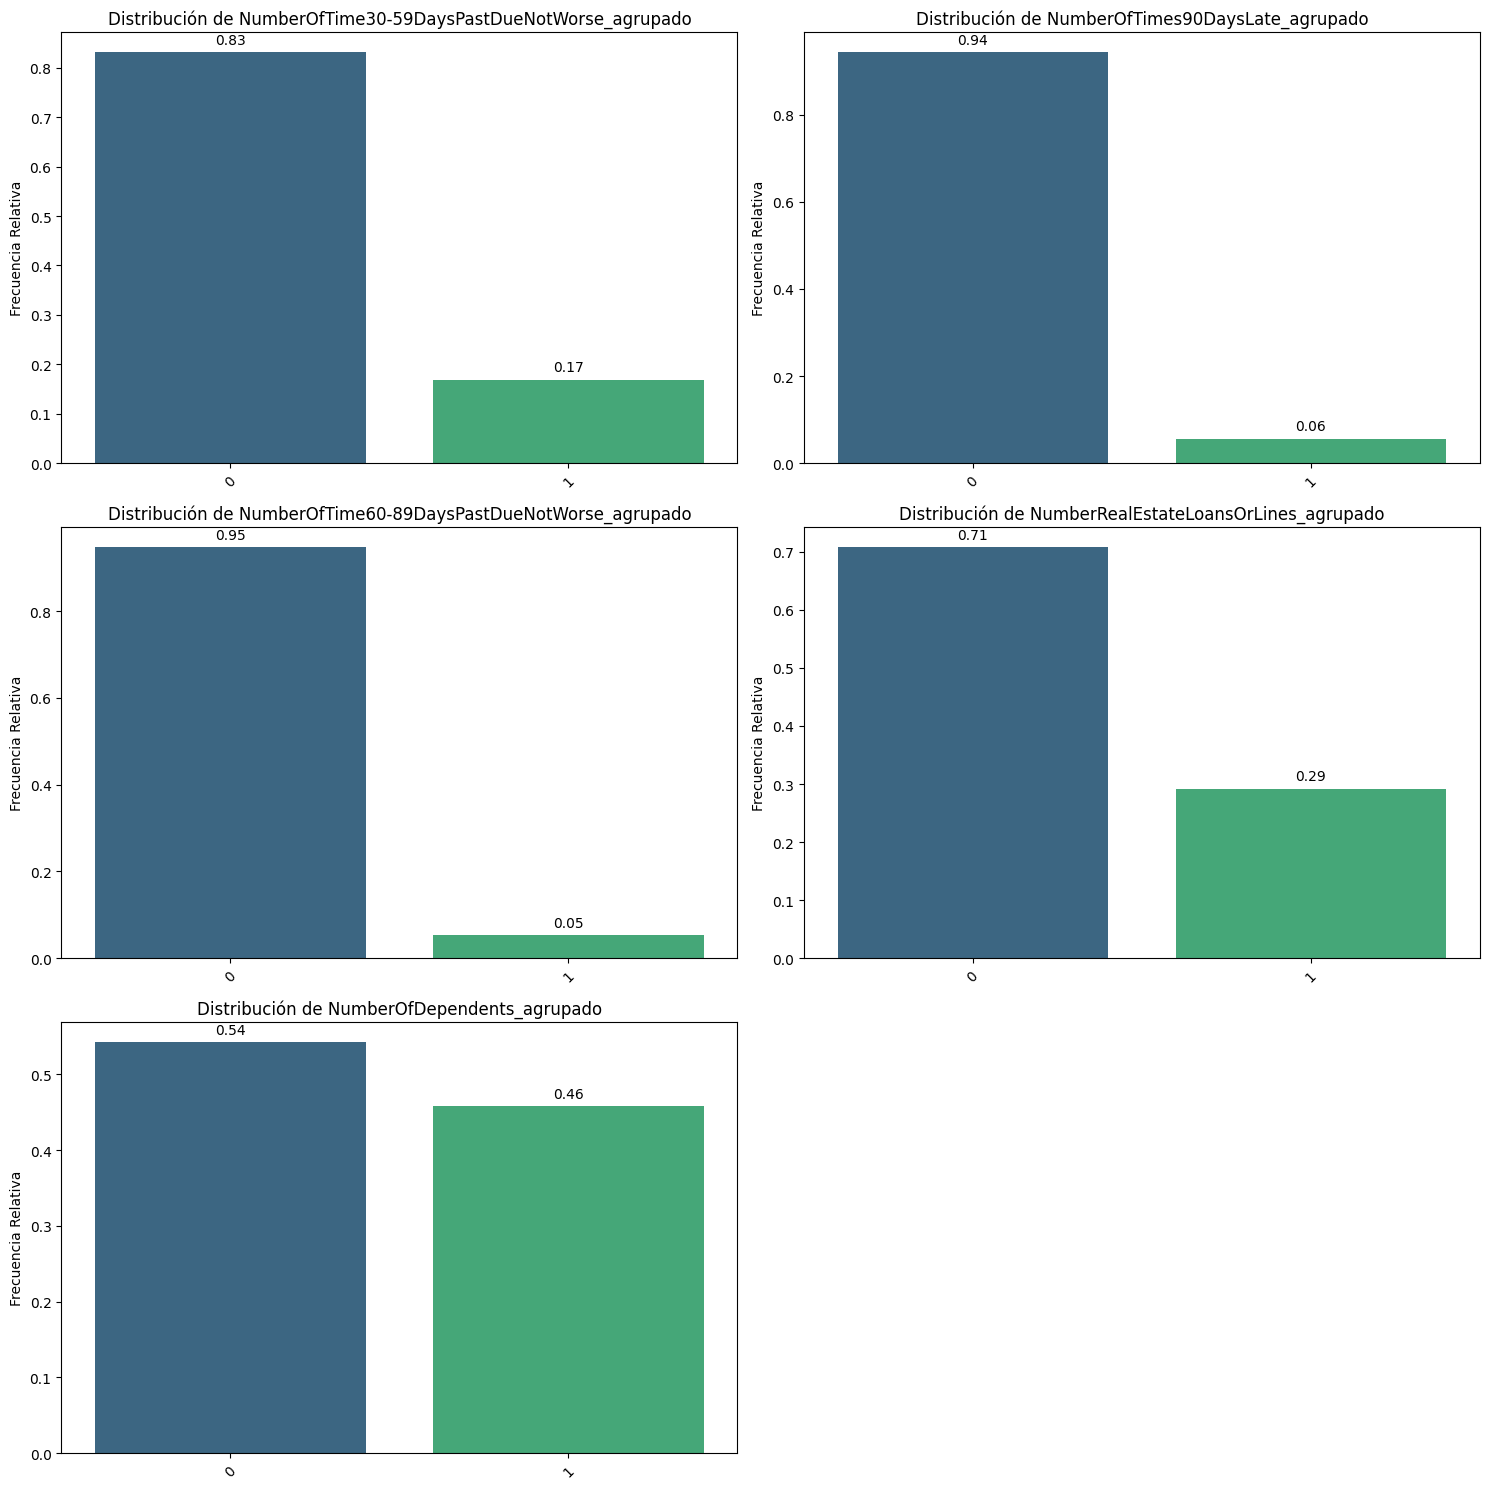

In [25]:
viz.pinta_distribucion_categoricas(train_set, columnas_categoricas=columnas_categoricas, relativa=True, mostrar_valores=True)

Como se observó en el análisis de estas variables antes de su conversión a categóricas, hay una alta agrupación en una las categorías creadas, excepto en la última "NumberOfDependents_agrupado"

Realizamos el análisis bivariante de las variables categóricas con el *target*

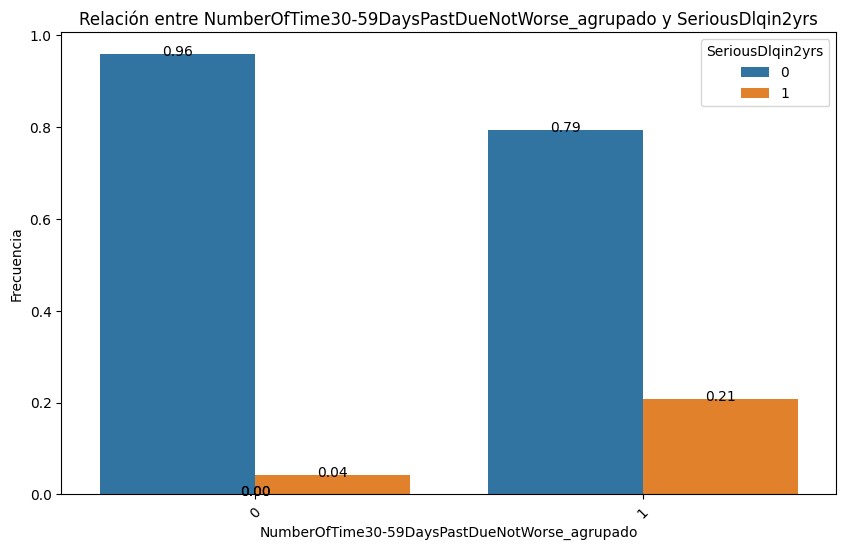

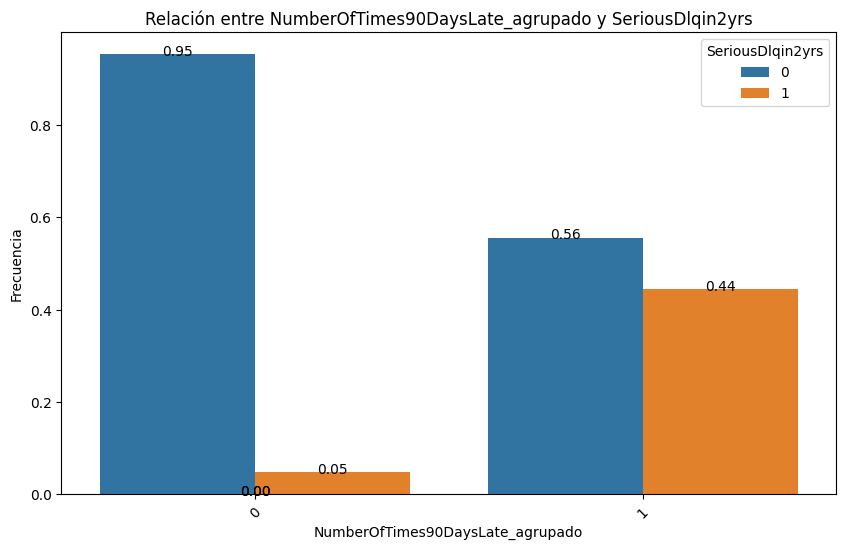

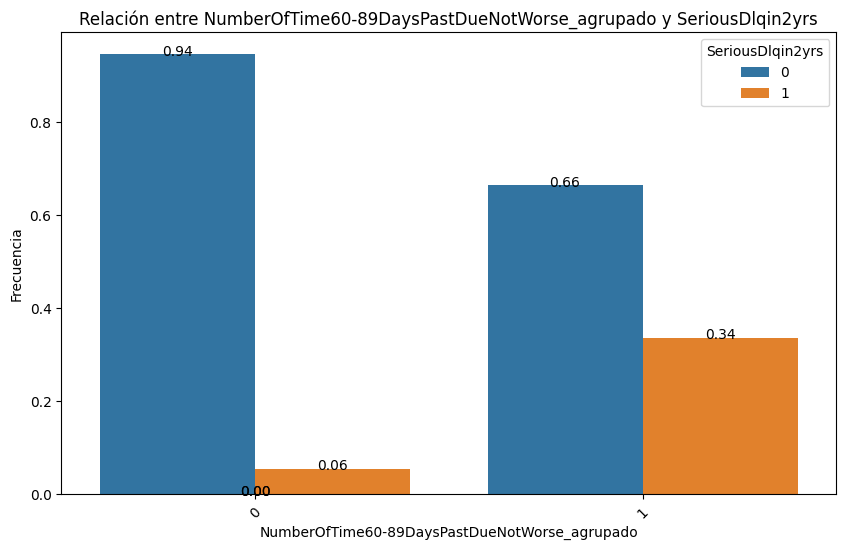

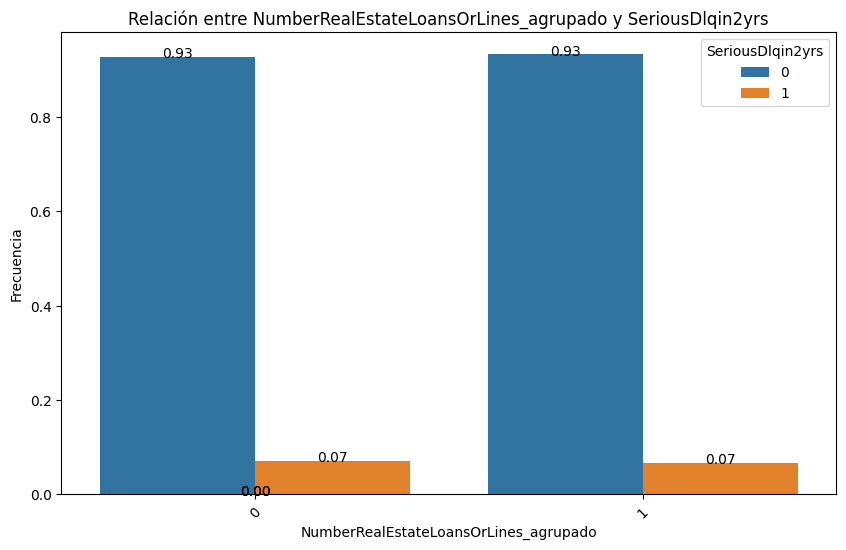

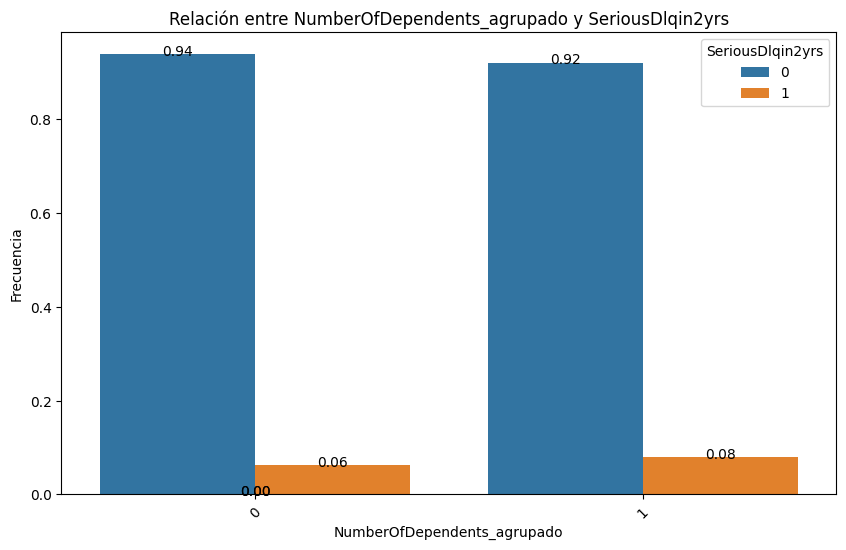

In [26]:
for columna_categoria in columnas_categoricas:
    viz.plot_categorical_relationship_fin(train_set, cat_col1=columna_categoria, cat_col2=target, relative_freq=True, show_values=True, size_group=2)

Se observa claramente que las variables "NumberRealEstateLoansOrLines_agrupado" y "NumberOfDependents_agrupado" no van a aportar nada al modelo, por lo que no nos las quedaremos como *features* categóricas

In [27]:
features_cat = columnas_categoricas.copy()
categoria_eliminar = ["NumberRealEstateLoansOrLines_agrupado", "NumberOfDependents_agrupado",]

for columna in categoria_eliminar:
    features_cat.remove(columna)

features_cat

['NumberOfTime30-59DaysPastDueNotWorse_agrupado',
 'NumberOfTimes90DaysLate_agrupado',
 'NumberOfTime60-89DaysPastDueNotWorse_agrupado']

**COMENTARIO**: Si siguieramos un proceso riguroso, las relaciones de las variables con el *target* se deben confirmar mediante los correspondientes tests. En este caso, y por simplicidad ya que no es el objetivo principal del bloque, no se realizan

### 2.2. Tratamiento de *features*

### 2.2.1. *Features* numéricas

Aplicaremos el tratamiento para adecuar las *features* numéricas al modelo de Regresión Logística y el modelo KNN ya que son sensibles a las escalas

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,9452.0,0.335207,0.362233,0.0,0.034869,0.179211,0.587533,6.0
age,9452.0,51.491536,14.499298,21.0,41.000000,51.000000,62.000000,101.0
DebtRatio,9452.0,0.486047,2.505031,0.0,0.146204,0.297564,0.477876,96.0
MonthlyIncome,9452.0,6868.428058,12580.543336,0.0,3466.000000,5441.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,9452.0,8.794647,5.139555,0.0,5.000000,8.000000,11.000000,49.0


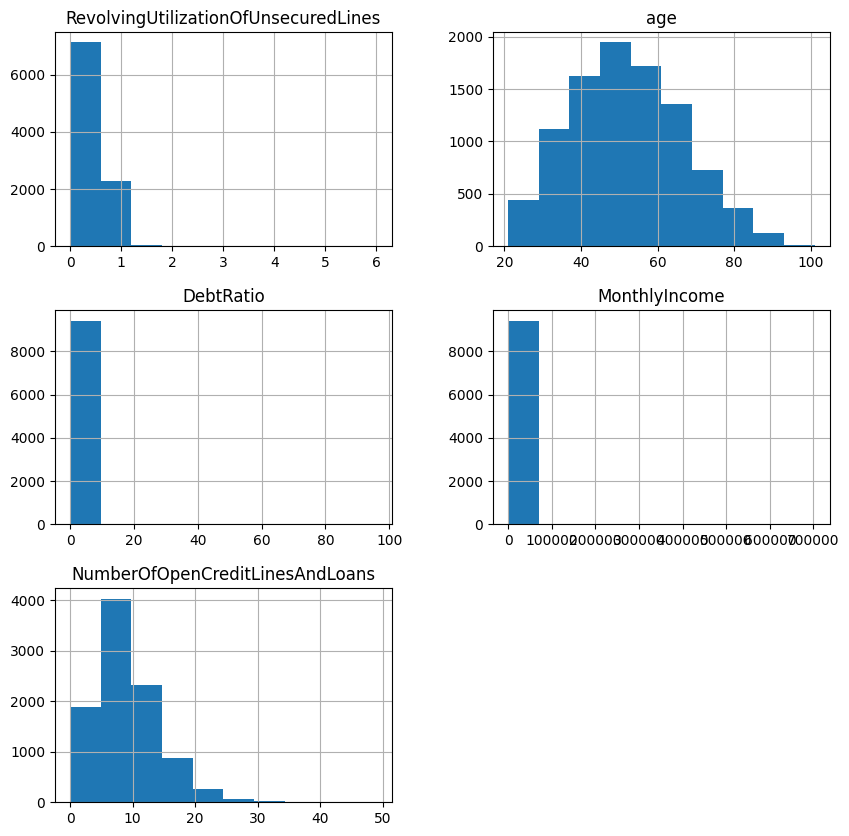

In [28]:
train_set[features_num].hist(figsize=(10,10));
train_set[features_num].describe().T

Presentan rangos diversos y además convendría aplicar la raiz cúbica a las variables "RevolvingUtilizationOfUnsecuredLines", "DebtRatio", "MonthlyIncome" y "NumberOfOpenCreditLinesAndLoans" para tratar de normalizarlas

Aplicamos la raíz cúbica (no aplicamos el logaritmo porque hay valores a 0) a los valores para tratar de centrarlos, tanto en train como en test 

In [29]:
#Realizamos una copia del DataFrame de train y test originales
train_set_escalado = train_set.copy()
test_set_escalado = test_set.copy()

#Creamos una lista con las columnas a aplicar la raiz cúbica
columnas_cbrt = [columna for columna in features_num if columna != "age"]

for columna in columnas_cbrt:
    train_set_escalado[columna] = train_set_escalado[columna].apply(np.cbrt)
    test_set_escalado[columna] = test_set_escalado[columna].apply(np.cbrt)

Visualizamos la distribución de las *features* numéricas de train tras aplicar la raiz cúbica

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,9452.0,0.566198,0.304126,0.0,0.326697,0.563795,0.837550,1.817121
age,9452.0,51.491536,14.499298,21.0,41.000000,51.000000,62.000000,101.000000
DebtRatio,9452.0,0.648270,0.283316,0.0,0.526809,0.667616,0.781817,4.578857
MonthlyIncome,9452.0,17.789800,4.494499,0.0,15.133621,17.588396,20.246939,88.895977
NumberOfOpenCreditLinesAndLoans,9452.0,1.974365,0.443981,0.0,1.709976,2.000000,2.223980,3.659306


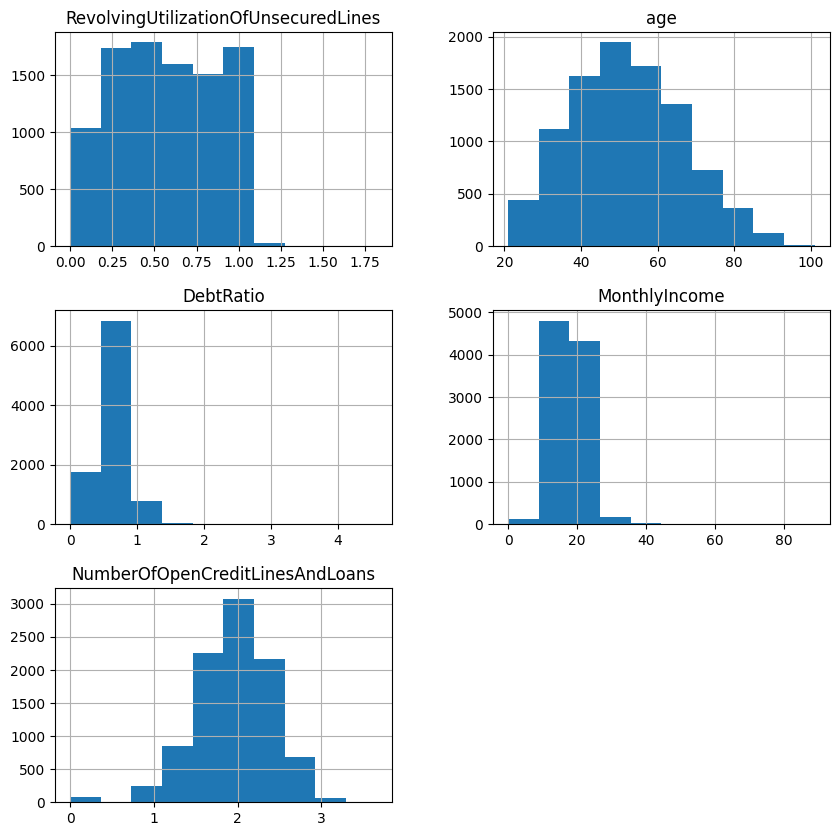

In [30]:
train_set_escalado[features_num].hist(figsize=(10,10))
train_set_escalado[features_num].describe().T

Algo mejora la distribución en algunas variables. Ahora escalamos las variables numéricas de los DataFrames de train y test

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train_set_escalado[features_num]) #Hacemos el fit solo con los datos de train

train_set_escalado[features_num] = scaler.transform(train_set_escalado[features_num])
test_set_escalado[features_num] = scaler.transform(test_set_escalado[features_num])

Visualizamos la distribución de las *features* numéricas tras aplicar el escalado

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,9452.0,0.311591,0.167367,0.0,0.179788,0.310268,0.460921,1.0
age,9452.0,0.381144,0.181241,0.0,0.250000,0.375000,0.512500,1.0
DebtRatio,9452.0,0.141579,0.061875,0.0,0.115053,0.145804,0.170745,1.0
MonthlyIncome,9452.0,0.200119,0.050559,0.0,0.170240,0.197854,0.227760,1.0
NumberOfOpenCreditLinesAndLoans,9452.0,0.539546,0.121329,0.0,0.467295,0.546552,0.607760,1.0


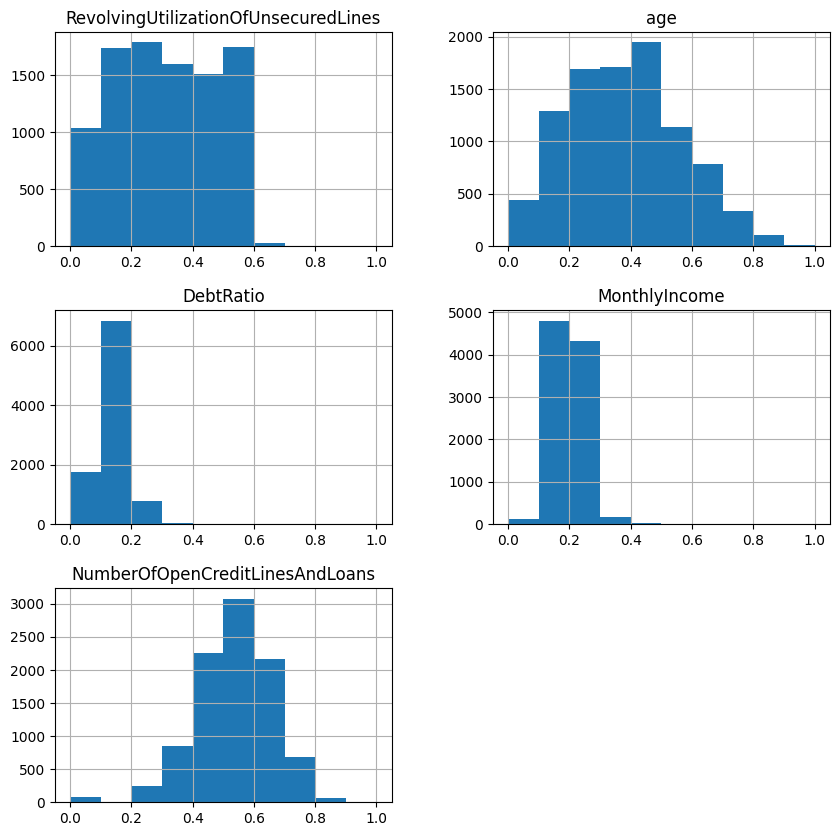

In [32]:
train_set_escalado[features_num].hist(figsize=(10,10))
train_set_escalado[features_num].describe().T

### 2.2.2. *Features* categóricas

Las *features* categóricas ya han sido convertidas a valores numéricos (0 y 1) en su creación a partir de las variables numéricas

### 2.3. Elección del modelo de Regresión Logística, RandomForest o KNN

Creamos los DataFrames X e y

In [34]:
#Para el modelo RandomForest
X_train = train_set[features_num+features_cat].copy()
y_train = train_set[target].copy()

X_test = test_set[features_num+features_cat].copy()
y_test = test_set[target].copy()

#Para los modelos de Regresión Logística y KNN
X_train_escalado = train_set_escalado[features_num+features_cat].copy()
X_test_escalado = test_set_escalado[features_num+features_cat].copy()


Instanciamos los modelos que servirán de *baseline* y realizamos la validación cruzada atendiendo al *recall* medio

In [35]:
#Regresión logística
base_rl_clf = LogisticRegression(max_iter = 10000, random_state = 42) 

#RandomForest
base_rf_clf = RandomForestClassifier(max_depth=5, random_state= 42)

#KNN
base_knn_clf = KNeighborsClassifier(n_neighbors = 5)

In [36]:
val_score = {}

for nombre, modelo in zip(["LogisticRegression", "RandomForest","KNN"],[base_rl_clf, base_rf_clf, base_knn_clf]):
    
    print(f"Score en validación cruzada para {nombre}:")
    
    if nombre == "RandomForest":
        metricas = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")

    else: 
        metricas = cross_val_score(modelo, X_train_escalado, y_train, cv = 5, scoring = "balanced_accuracy")
    
    balanced_accuracy = np.mean(metricas)
    print(balanced_accuracy)
        
    #Guardamos la métrica en el diccionario
    val_score[nombre] = balanced_accuracy
        
    print("\n")       

#Seleccionamos el modelo con la mejor métrica en validación cruzada
print(f"Modelo escogido en validación cruzada: {list(val_score.keys())[np.argmax(list(val_score.values()))]}")

Score en validación cruzada para LogisticRegression:
0.5869348109882827


Score en validación cruzada para RandomForest:
0.5273598271711978


Score en validación cruzada para KNN:
0.5867500229498258


Modelo escogido en validación cruzada: LogisticRegression


Tendremos que optimizar los hiperparámetros para ambos modelos, el de Regresión Logística y KNN, para salir de dudas ya que obtienen un *score* muy similar

### 2.4. Optimización de los hiperparámetros para el modelo de Regresión Logística y KNN

Emplearemos *GridSearch* para la obtención de los hiperparámetros que optimizan el modelo de Regresión Logística. Definimos un *grid* que incluya los hiperparámetros por defecto, para que se tenga en cuenta el modelo evaluado en validación cruzada

In [37]:
grid_rl = {
    "max_iter": [5000,10000,20000],
    "class_weight": ["balanced", None]
}

rl_grid = GridSearchCV(base_rl_clf, param_grid = grid_rl, cv=5, scoring = "balanced_accuracy")

rl_grid.fit(X_train_escalado, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_iter': [5000, 10000, 20000]},
             scoring='balanced_accuracy')

Mostramos los hiperparámetros que optimizan el modeloy el *score*

In [49]:
print(rl_grid.best_params_)

{'class_weight': 'balanced', 'max_iter': 5000}


In [50]:
print(rl_grid.best_score_)

0.763997180115373


Evaluamos los errores

In [52]:
y_pred_train = rl_grid.best_estimator_.predict(X_train_escalado)
    
report_rl_train = classification_report(y_train, y_pred_train)
print(report_rl_train)

              precision    recall  f1-score   support

           0       0.97      0.81      0.89      8789
           1       0.22      0.71      0.34       663

    accuracy                           0.81      9452
   macro avg       0.60      0.76      0.61      9452
weighted avg       0.92      0.81      0.85      9452



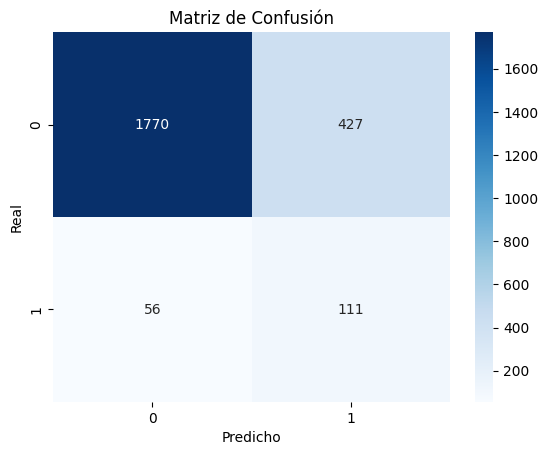

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2197
           1       0.21      0.66      0.31       167

    accuracy                           0.80      2364
   macro avg       0.59      0.74      0.60      2364
weighted avg       0.92      0.80      0.84      2364



In [53]:
#Predicciones de test
y_pred_test = rl_grid.best_estimator_.predict(X_test_escalado)

#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

#Visualizamos la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

#Mostramos el classification report    
report_rl_test = classification_report(y_test, y_pred_test)
print(report_rl_test)

Comentarios:
* Obtenemos un modelo que generalizará bien
* En test baja el *recall* de la clase 1, de un 71% a un 66%
* Obtenemos un buen 74% de *recall* medio pero a costa de una baja precisión (21%) en la clase 1

Emplearemos *GridSearch* para la obtención de los hiperparámetros que optimizan el modelo KNN. Definimos un *grid* que incluya los hiperparámetros por defecto, para que se tenga en cuenta el modelo evaluado en validación cruzada

In [54]:
grid_knn = {
    "n_neighbors": range(1,21),
}

knn_grid = GridSearchCV(base_knn_clf, param_grid = grid_knn, cv=5, scoring = "balanced_accuracy")

knn_grid.fit(X_train_escalado, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)},
             scoring='balanced_accuracy')

Mostramos los hiperparámetros que optimizan el modelo y el *score*

In [55]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


In [56]:
print(knn_grid.best_score_)

0.5956625465784804


Evaluamos los errores

In [57]:
y_pred_train = knn_grid.best_estimator_.predict(X_train_escalado)
    
report_knn_train = classification_report(y_train, y_pred_train)
print(report_knn_train)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8789
           1       0.70      0.38      0.49       663

    accuracy                           0.95      9452
   macro avg       0.83      0.68      0.73      9452
weighted avg       0.94      0.95      0.94      9452



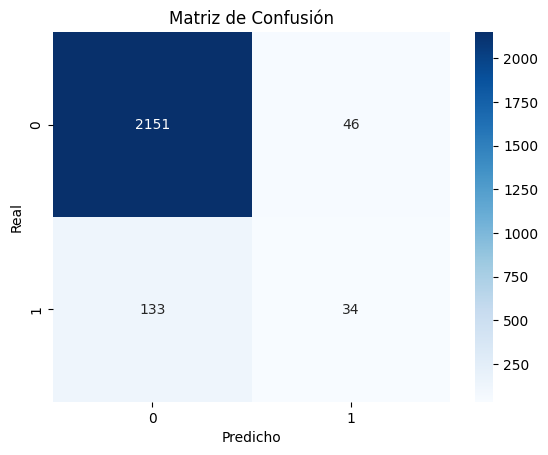

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2197
           1       0.42      0.20      0.28       167

    accuracy                           0.92      2364
   macro avg       0.68      0.59      0.62      2364
weighted avg       0.91      0.92      0.91      2364



In [58]:
#Predicciones de test
y_pred_test = knn_grid.best_estimator_.predict(X_test_escalado)

#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

#Visualizamos la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

#Mostramos el classification report    
report_knn_test = classification_report(y_test, y_pred_test)
print(report_knn_test)

Comentarios:
* Obtenemos un modelo que no generalizará tan bien como la regresión logística ya que hay mucha variación entre las métricas de la clase 1
* En test baja mucho la *precision* y el *recall* de la clase 1
* Obtenemos un 59 % de *recall* medio, inferior al de la regresión logística, pero la precisión es mejor (un 42%, aunque baja) en la clase 1

### 2.5. Evaluación de errores y selección del modelo

Con los resultados obtenidos para ambos modelos escogeríamos la regresión logística ya que ofrece mejor *recall* medio. No obstante, tiene una baja precisión en la clase 1 que habría que intentar
mejorarla. Vamos a aplicar técnicas de *over-sampling* y *under-sampling* por si mejoraran los resultados del modelo de regresión logística

**Over-sampling**

In [59]:
#Aplicamos SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_escalado, y_train)

Mostramos la distribución final del *target* y el nuevo tamaño del X_train tras aplicar SMOTE

In [60]:
y_train_smote.value_counts(True)

SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [61]:
X_train_smote.shape

(17578, 8)

In [62]:
X_train_escalado.shape

(9452, 8)

Han aumentado las filas de 9452 a 17578

Entrenamos el modelo y evaluamos contra test

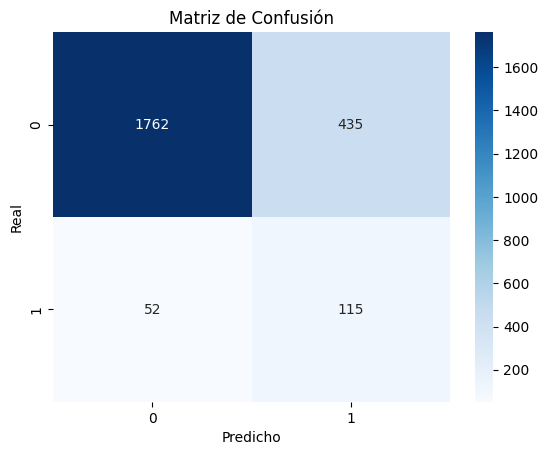

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      2197
           1       0.21      0.69      0.32       167

    accuracy                           0.79      2364
   macro avg       0.59      0.75      0.60      2364
weighted avg       0.92      0.79      0.84      2364



In [66]:
#Entrenamos el modelo
rl_smote = LogisticRegression(max_iter = 5000, random_state = 42)
rl_smote.fit(X_train_smote, y_train_smote)

#Predicciones de test
y_pred_smote = rl_smote.predict(X_test_escalado)

#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_smote)

#Visualizamos la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

#Mostramos el classification report    
report_rl_smote = classification_report(y_test, y_pred_smote)
print(report_rl_smote)

Conseguimos mejorar un poco el *recall* medio pero *precision* sigue igual con un 21%

**Under-sampling**

In [67]:
#Separamos las clases mayoritaria y minoritaria
clase_mayoritaria = X_train_escalado[y_train == 0]
clase_minoritaria = X_train_escalado[y_train == 1]

#Bajomuestreo de la clase mayoritaria
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria, replace=False, n_samples=len(clase_minoritaria), random_state=42)

#Combinamos la clase minoritaria con la clase mayoritaria bajomuestreada
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], y_train.loc[clase_minoritaria.index]])

Mostramos la distribución final del *target* y el nuevo tamaño del X_train tras aplicar la técnica

In [68]:
y_train_bajomuestreo.value_counts(True)

SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [69]:
X_train_bajomuestreo.shape

(1326, 8)

In [70]:
X_train_escalado.shape

(9452, 8)

Han disminuido las filas de 9452 a 1326

Entrenamos el modelo y evaluamos contra test

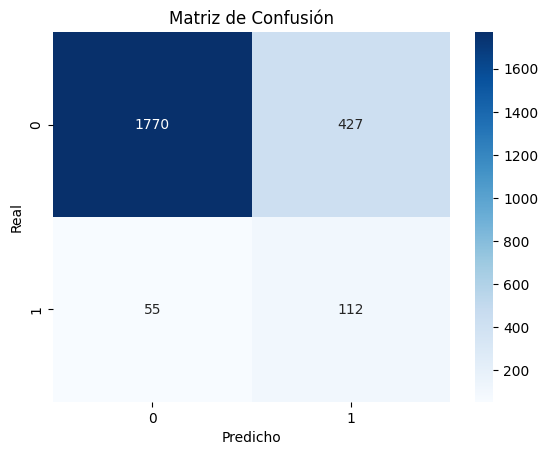

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2197
           1       0.21      0.67      0.32       167

    accuracy                           0.80      2364
   macro avg       0.59      0.74      0.60      2364
weighted avg       0.92      0.80      0.84      2364



In [71]:
#Entrenamos el modelo
rl_bajomuestreo = LogisticRegression(max_iter = 5000, random_state = 42)
rl_bajomuestreo.fit(X_train_bajomuestreo, y_train_bajomuestreo)

#Predicciones de test
y_pred_bajomuestreo = rl_bajomuestreo.predict(X_test_escalado)

#Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_bajomuestreo)

#Visualizamos la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

#Mostramos el classification report    
report_rl_bajomuestreo = classification_report(y_test, y_pred_bajomuestreo)
print(report_rl_bajomuestreo)

No se consigue ninguna mejoría, aplicar ésta técnica ha resultado equivalente a indicar el hiperparámetro class_weight="balanced" cuando se instancia el modelo